In [1]:
import numpy as np

import scipy.io.wavfile as wavfile
from torch.utils.data import Dataset

from IPython.display import clear_output # must not leak any of the data

import psstdata # pip install psstdata==1.0.1, see https://aphasia.talkbank.org/derived/RaPID/

# Load Data
This will prompt for credentials if not already saved in ~/config/psstdata/settings.json

In [2]:
data = psstdata.load(local_dir="../.data/psst-data") # type: ignore
clear_output()

# Process Data

In [3]:
def audio_file_to_array(input_path, desired_sample_rate=16000):
    rate, data = wavfile.read(input_path)
    if rate != desired_sample_rate:
        data = np.interp(
            np.linspace(0, len(data), int(len(data) * desired_sample_rate / rate)),
            np.arange(len(data)),
            data,
        ).astype(np.int16)
    return data
clear_output()

In [4]:
ARPABET2IPA = {'AA':'ɑ','AE':'æ','AH':'ʌ','AH0':'ə','AO':'ɔ','AW':'aʊ','AY':'aɪ','EH':'ɛ','ER':'ɝ','ER0':'ɚ','EY':'eɪ','IH':'ɪ','IH0':'ɨ','IY':'i','OW':'oʊ','OY':'ɔɪ','UH':'ʊ','UW':'u','B':'b','CH':'tʃ','D':'d','DH':'ð','EL':'l̩ ','EM':'m̩','EN':'n̩','F':'f','G':'ɡ','HH':'h','JH':'dʒ','K':'k','L':'l','M':'m','N':'n','NG':'ŋ','P':'p','Q':'ʔ','R':'ɹ','S':'s','SH':'ʃ','T':'t','TH':'θ','V':'v','W':'w','WH':'ʍ','Y':'j','Z':'z','ZH':'ʒ'}
IPA_SUBSTITUTIONS = {
    'ɝ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'ɚ': 'ɹ',   # Simplify rhotacized schwa to 'ɹ'
    'l̩': 'l',   # Remove syllabic marker from 'l̩'
    'm̩': 'm',   # Remove syllabic marker from 'm̩'
    'n̩': 'n',   # Remove syllabic marker from 'n̩'
    '̩': '',     # Remove syllabic marker
    'ɨ': 'i',    # Replace high central unrounded vowel with high front unrounded vowel
    ' ': '',     # Remove nasalization marker
}
for k in ARPABET2IPA.keys():
    if ARPABET2IPA[k] in IPA_SUBSTITUTIONS:
        ARPABET2IPA[k] = IPA_SUBSTITUTIONS[ARPABET2IPA[k]]
clear_output()

In [5]:
class PSSTDataset(Dataset):
    def __init__(self, split="train"):
        if split == "train":
            self.utterances = data.train
        elif split == "valid":
            self.utterances = data.valid
        elif split == "test":
            self.utterances = data.test
        else:
            raise ValueError(f"Unknown split: {split}")

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterance = self.utterances[index]
        ipa = "".join(map(lambda x: ARPABET2IPA[x] if x in ARPABET2IPA else '<unk>', utterance.transcript.split(' ')))
        audio = audio_file_to_array(utterance.filename_absolute)
        return ipa, audio

clear_output()

In [6]:
# train = PSSTDataset("train")
# valid = PSSTDataset("valid")
test = PSSTDataset("test")
clear_output()

eɪhaʊs


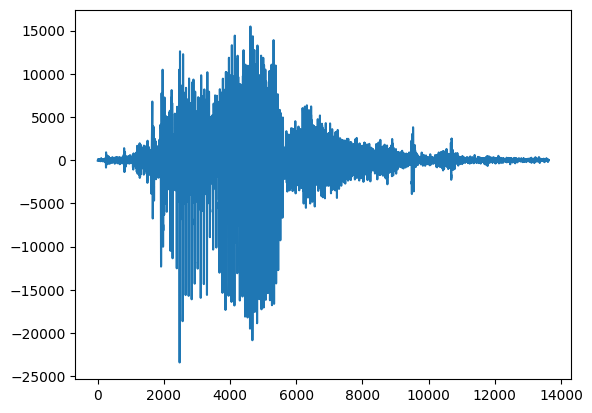

In [7]:
import matplotlib.pyplot as plt
print(test[0][0])
plt.plot(test[0][1])
plt.show()


In [8]:
import torch
from transformers import AutoProcessor, AutoModelForCTC
clear_output()
TARGET_SAMPLE_RATE = 16000

In [11]:
import panphon.distance

def cer(prediction, ground_truth):
    # Convert input lists to strings if they're lists
    if isinstance(prediction, list):
        prediction = "".join(prediction)
    if isinstance(ground_truth, list):
        ground_truth = "".join(ground_truth)

    # Handle empty strings
    if len(ground_truth) == 0:
        return 1.0 if len(prediction) > 0 else 0.0

    # Initialize the matrix
    matrix = np.zeros((len(prediction) + 1, len(ground_truth) + 1))

    # Fill first row and column
    for i in range(len(prediction) + 1):
        matrix[i, 0] = i
    for j in range(len(ground_truth) + 1):
        matrix[0, j] = j

    # Fill in the rest of the matrix
    for i in range(1, len(prediction) + 1):
        for j in range(1, len(ground_truth) + 1):
            if prediction[i - 1] == ground_truth[j - 1]:
                matrix[i, j] = matrix[i - 1, j - 1]
            else:
                substitution = matrix[i - 1, j - 1] + 1
                insertion = matrix[i, j - 1] + 1
                deletion = matrix[i - 1, j] + 1
                matrix[i, j] = min(substitution, insertion, deletion)

    # Calculate CER
    distance = matrix[len(prediction), len(ground_truth)]
    return distance / len(ground_truth)


def preprocess_ipa(ipa_string):
    """Preprocess an IPA string by removing unsupported symbols. Suggestions by David Mortensen, creator of panphon."""
    replacement_map = {
        "ɚ": "ɹ̩",  # Convert /ɚ/ to /ɹ/ (non-syllabic r)
        "ɝ": "ɹ",  # Convert /ɝ/ to /ɹ/ (non-syllabic r)
        "ː": "",  # Remove length mark (or duplicate previous vowel if length is important)
        "͡": "",  # Remove tie bar (or split into components if part of an affricate)
        "g": "ɡ",  # replace two versions of g, TIMIT uses ascii g and STANDARD IPA uses unicode g
    }
    processed_string = "".join(replacement_map.get(char, char) for char in ipa_string)

    return processed_string


def panphon_model_eval(label, predicted):
    label_sequence = preprocess_ipa(label)
    pred_sequence = preprocess_ipa(predicted)

    weighted_feature_dist = panphon.distance.Distance().weighted_feature_edit_distance(
        label_sequence, pred_sequence
    )
    cer_score = cer(predicted, label)

    return cer_score, weighted_feature_dist

In [13]:

# MODEL_IDS = [
#     "KoelLabs/xlsr-timit-c0",
#     "KoelLabs/xlsr-timit-d0",
#     "KoelLabs/xlsr-timit-b1",
#     "KoelLabs/xlsr-timit-c1",
#     "KoelLabs/xlsr-timit-d1",
#     "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-53-buckeye-ipa",
#     "mrrubino/wav2vec2-large-xlsr-53-l2-arctic-phoneme",
#     "ginic/vary_individuals_young_only_3_wav2vec2-large-xlsr-buckeye-ipa",
#     "ginic/gender_split_70_female_4_wav2vec2-large-xlsr-buckeye-ipa",
#     "facebook/wav2vec2-lv-60-espeak-cv-ft",
#     "speech31/XLS-R-300m-english-ipa",
#     "speech31/wavlm-large-english-ipa",
#     "vitouphy/wav2vec2-xls-r-300m-timit-phoneme",
#     "facebook/wav2vec2-xlsr-53-espeak-cv-ft",
#     "KoelLabs/xlsr-timit-a0",
#     "speech31/wav2vec2-large-TIMIT-IPA",
#     "ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000",
#     "speech31/wav2vec2-large-english-TIMIT-phoneme_v3",
#     "ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns",
#     "snu-nia-12/wav2vec2-large_nia12_phone-ipa_english",
#     "speech31/wav2vec2-large-TIMIT-IPA2",
#     "Jubliano/wav2vec2-large-xls-r-300m-ipa-INTERNATIONAL1.5",
#     "Jubliano/wav2vec2-large-xls-r-300m-ipa-INTERNATIONAL1.9.2WithoutSpaces",
#     "Jubliano/wav2vec2-large-xls-r-300m-ipa-nl"
# ]

In [15]:
import torch
from transformers import AutoProcessor, AutoModelForCTC
import gc
from collections import defaultdict
import difflib
from typing import Dict, List, Tuple

BATCH_SIZE = 4
average_cer = 0
average_feature_distance = 0
data = test  # Use the PSSTDataset class
amount = len(data)  # Get length from dataset
results = {}

# List of all model IDs to evaluate
MODEL_IDS = [
    "KoelLabs/xlsr-timit-a1",
]

def transcribe_batch(batch, model, processor, device):
    input_values = processor([x[1] for x in batch], sampling_rate=16000, return_tensors="pt", padding=True).input_values.type(torch.float32).to(device)
    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    return [processor.decode(ids) for ids in predicted_ids] 

def analyze_substitution_patterns(ground_truth: str, prediction: str) -> Dict[str, List[str]]:
    """Analyze character substitution patterns between ground truth and prediction."""
    matcher = difflib.SequenceMatcher(None, ground_truth, prediction)
    substitutions = defaultdict(list)
    
    for op, i1, i2, j1, j2 in matcher.get_opcodes():
        if op == 'replace':
            gt_chars = ground_truth[i1:i2]
            pred_chars = prediction[j1:j2]
            substitutions[gt_chars].append(pred_chars)
    
    return dict(substitutions)

def analyze_model_patterns(high_cer_cases: List[dict]) -> Dict:
    """Analyze patterns in high CER cases."""
    patterns = {
        'substitutions': defaultdict(int),
        'length_diffs': [],
        'common_additions': defaultdict(int),
        'common_deletions': defaultdict(int)
    }
    
    for case in high_cer_cases:
        gt = case['ground_truth']
        pred = case['prediction']
        
        # Analyze length differences
        patterns['length_diffs'].append(len(pred) - len(gt))
        
        # Find substitutions
        subs = analyze_substitution_patterns(gt, pred)
        for orig, replacements in subs.items():
            for repl in replacements:
                patterns['substitutions'][f"{orig} → {repl}"] += 1
        
        # Find additions and deletions using difflib
        matcher = difflib.SequenceMatcher(None, gt, pred)
        for op, i1, i2, j1, j2 in matcher.get_opcodes():
            if op == 'insert':
                added = pred[j1:j2]
                patterns['common_additions'][added] += 1
            elif op == 'delete':
                deleted = gt[i1:i2]
                patterns['common_deletions'][deleted] += 1
    
    # Convert defaultdicts to regular dicts
    patterns['substitutions'] = dict(sorted(patterns['substitutions'].items(), 
                                          key=lambda x: x[1], reverse=True))
    patterns['common_additions'] = dict(sorted(patterns['common_additions'].items(), 
                                             key=lambda x: x[1], reverse=True))
    patterns['common_deletions'] = dict(sorted(patterns['common_deletions'].items(), 
                                             key=lambda x: x[1], reverse=True))
    
    return patterns

def evaluate_model(model_id):
    print(f"\nEvaluating model: {model_id}")
    
    high_cer_cases = []
    suspicious_cases = []  # Cases with high CER but low feature distance
    
    try:
        processor = AutoProcessor.from_pretrained(model_id)
        model = AutoModelForCTC.from_pretrained(model_id).to(DEVICE)
        
        average_cer = 0
        average_feature_distance = 0
        
        for i in range(0, amount, BATCH_SIZE):
            if DEVICE == 'cuda':
                torch.cuda.empty_cache()
            elif DEVICE == 'mps':
                torch.mps.empty_cache()
                
            size = min(BATCH_SIZE, amount - i)
            batch = [data[idx] for idx in range(i, i+size)]
            transcriptions = transcribe_batch(batch, model, processor, DEVICE)
            
            for j in range(size):
                true_ipa = batch[j][0]
                cer_score, feature_distance = panphon_model_eval(true_ipa, transcriptions[j])
                average_cer += cer_score
                average_feature_distance += feature_distance
                
                case_data = {
                    'ground_truth': true_ipa,
                    'prediction': transcriptions[j],
                    'cer': cer_score,
                    'fer': feature_distance
                }
                
                # Store cases where CER > 1
                if cer_score > 1:
                    high_cer_cases.append(case_data)
                    
                    # Identify suspicious cases (high CER, low feature distance)
                    if feature_distance < 28:  # Threshold based on your data
                        suspicious_cases.append(case_data)
            
            print(f"Progress: {min(i + BATCH_SIZE, amount)}/{amount}", end='\r')
        
        final_cer = average_cer / amount
        final_feature_distance = average_feature_distance / amount
        
        # Analyze patterns in suspicious cases
        suspicious_patterns = None
        if suspicious_cases:
            suspicious_patterns = analyze_model_patterns(suspicious_cases)
        
        results[model_id] = {
            'cer': final_cer,
            'feature_distance': final_feature_distance,
            'high_cer_cases': high_cer_cases,
            'suspicious_cases': suspicious_cases,
            'suspicious_patterns': suspicious_patterns
        }
        
        print(f"\nResults for {model_id}:")
        print(f"Average CER: {final_cer:.4f}")
        print(f"Average Feature Distance: {final_feature_distance:.4f}")
        
        if suspicious_cases:
            print(f"\nFound {len(suspicious_cases)} suspicious cases (CER > 1, Feature Distance < 28):")
            print("\nPattern Analysis:")
            
            if suspicious_patterns:
                # Print top substitution patterns
                print("\nTop 5 Character Substitution Patterns:")
                for pattern, count in list(suspicious_patterns['substitutions'].items())[:5]:
                    print(f"  {pattern}: {count} times")
                
                # Print length statistics
                length_diffs = suspicious_patterns['length_diffs']
                avg_length_diff = sum(length_diffs) / len(length_diffs)
                print(f"\nAverage length difference: {avg_length_diff:.2f} characters")
                
                # Print common additions/deletions
                print("\nTop 3 Common Additions:")
                for added, count in list(suspicious_patterns['common_additions'].items())[:3]:
                    print(f"  Added '{added}': {count} times")
                
                print("\nTop 3 Common Deletions:")
                for deleted, count in list(suspicious_patterns['common_deletions'].items())[:3]:
                    print(f"  Deleted '{deleted}': {count} times")
            
            # Print example cases
            print("\nExample Suspicious Cases:")
            for idx, case in enumerate(suspicious_cases[:3], 1):  # Show first 3 cases
                print(f"\nCase {idx}:")
                print(f"Ground Truth: {case['ground_truth']}")
                print(f"Prediction:   {case['prediction']}")
                print(f"CER: {case['cer']:.4f}")
                print(f"FER: {case['fer']:.4f}")
                
                # Print character-by-character comparison
                print("\nCharacter comparison:")
                max_len = max(len(case['ground_truth']), len(case['prediction']))
                print("Ground Truth: " + " ".join(c.ljust(1) for c in case['ground_truth'].ljust(max_len)))
                print("Prediction:   " + " ".join(c.ljust(1) for c in case['prediction'].ljust(max_len)))
                
    except Exception as e:
        print(f"\nError evaluating {model_id}: {str(e)}")
        results[model_id] = {
            'error': str(e)
        }
    
    finally:
        if 'model' in locals():
            del model
        if 'processor' in locals():
            del processor
        gc.collect()
        if DEVICE == 'cuda':
            torch.cuda.empty_cache()
        elif DEVICE == 'mps':
            torch.mps.empty_cache()

def save_results():
    with open('model_evaluation_detailed_results.txt', 'w') as f:
        f.write("=== Model Evaluation Detailed Results ===\n\n")
        for model_id, result in results.items():
            f.write(f"{model_id}:\n")
            if 'error' in result:
                f.write(f"Error: {result['error']}\n")
            else:
                f.write(f"CER: {result['cer']:.4f}\n")
                f.write(f"Feature Distance: {result['feature_distance']:.4f}\n")
                
                if result.get('suspicious_cases'):
                    f.write(f"\nSuspicious Cases (High CER, Low Feature Distance): {len(result['suspicious_cases'])}\n")
                    if result.get('suspicious_patterns'):
                        f.write("\nPattern Analysis:\n")
                        f.write("\nTop Character Substitution Patterns:\n")
                        for pattern, count in list(result['suspicious_patterns']['substitutions'].items())[:10]:
                            f.write(f"  {pattern}: {count} times\n")
                        
                        length_diffs = result['suspicious_patterns']['length_diffs']
                        avg_length_diff = sum(length_diffs) / len(length_diffs)
                        f.write(f"\nAverage length difference: {avg_length_diff:.2f} characters\n")
                        
                        f.write("\nCommon Additions:\n")
                        for added, count in list(result['suspicious_patterns']['common_additions'].items())[:5]:
                            f.write(f"  Added '{added}': {count} times\n")
                        
                        f.write("\nCommon Deletions:\n")
                        for deleted, count in list(result['suspicious_patterns']['common_deletions'].items())[:5]:
                            f.write(f"  Deleted '{deleted}': {count} times\n")
                    
                    # Write example cases
                    f.write("\nExample Cases:\n")
                    for idx, case in enumerate(result['suspicious_cases'][:5], 1):
                        f.write(f"\nCase {idx}:\n")
                        f.write(f"Ground Truth: {case['ground_truth']}\n")
                        f.write(f"Prediction:   {case['prediction']}\n")
                        f.write(f"CER: {case['cer']:.4f}\n")
                        f.write(f"FER: {case['fer']:.4f}\n")
                        
            f.write("\n" + "="*50 + "\n\n")

if __name__ == "__main__":
    # Run evaluation for all models
    for model_id in MODEL_IDS:
        evaluate_model(model_id)
    
    # Save detailed results to file
    save_results()


Evaluating model: KoelLabs/xlsr-timit-a1


/home/arunasri/ML/venv/lib/python3.8/site-packages/panphon/distance.py:73: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  dogol_prime = yaml.load(f.read())


Progress: 652/652
Results for KoelLabs/xlsr-timit-a1:
Average CER: 0.7000
Average Feature Distance: 28.7476

Found 21 suspicious cases (CER > 1, Feature Distance < 28):

Pattern Analysis:

Top 5 Character Substitution Patterns:
  ʌʃ → oʊɡɪn: 1 times
  wɑʃɪŋ → əfɔɹʒʔɛn: 1 times
  ʊm → wæɡəθ: 1 times
  t → d: 1 times
  θbɹ → fl: 1 times

Average length difference: 2.29 characters

Top 3 Common Additions:
  Added 'm': 2 times
  Added 'fɹt': 1 times
  Added 'ðə': 1 times

Top 3 Common Deletions:
  Deleted 'b': 2 times
  Deleted 'k': 1 times
  Deleted 'ɔɹn': 1 times

Example Suspicious Cases:

Case 1:
Ground Truth: bɹʌʃ
Prediction:   ɹoʊɡɪn
CER: 1.5000
FER: 22.1250

Character comparison:
Ground Truth: b ɹ ʌ ʃ    
Prediction:   ɹ o ʊ ɡ ɪ n

Case 2:
Ground Truth: wɑʃɪŋ
Prediction:   əfɔɹʒʔɛn
CER: 1.6000
FER: 25.8750

Character comparison:
Ground Truth: w ɑ ʃ ɪ ŋ      
Prediction:   ə f ɔ ɹ ʒ ʔ ɛ n

Case 3:
Ground Truth: koʊm
Prediction:   owæɡəθ
CER: 1.5000
FER: 21.3125

Character comparison:

## PSST CHALLENGE performance
KoelLabs/xlsr-timit-b0
Average CER: 0.5556703733946625
Average feature distance: 25.241564417177916

